In [27]:
import os
import random
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import joblib
import seaborn as sns
from sklearn.utils.class_weight import compute_sample_weight

In [28]:
df = pd.read_csv('data.csv')

In [29]:
df.head()

,delivery_id,delivery_partner,package_type,vehicle_type,delivery_mode,region,weather_condition,distance_km,package_weight_kg,delivery_time_hours,expected_time_hours,delayed,delivery_status,delivery_rating,delivery_cost
0,250.99,delhivery,automobile parts,bike,same day,west,clear,297.0,46.96,1970-01-01 00:00:00.000000008,1970-01-01 00:00:00.000000008,no,delivered,3,1632.7206
1,250.99,xpressbees,cosmetics,ev van,express,central,cold,89.6,47.39,1970-01-01 00:00:00.000000002,1970-01-01 00:00:00.000000003,no,delivered,5,640.1700
2,250.99,shadowfax,groceries,truck,two day,east,rainy,273.5,26.89,1970-01-01 00:00:00.000000010,1970-01-01 00:00:00.000000016,no,delivered,4,1448.1700
3,250.99,dhl,electronics,ev van,same day,east,cold,269.7,12.69,1970-01-01 00:00:00.000000006,1970-01-01 00:00:00.000000008,no,delivered,3,1486.5700
4,250.99,dhl,clothing,van,two day,north,foggy,256.7,37.02,1970-01-01 00:00:00.000000009,1970-01-01 00:00:00.000000016,no,delivered,4,1394.5600


In [30]:
SEED = 42

os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
keras.utils.set_random_seed(SEED)

In [31]:
# Función personalizada para arreglar el formato de tiempo sucio
def extraer_horas(valor):
    try:
        valor_str = str(valor)
        # Tomamos lo que está después del punto final (ej: "000000008")
        # y lo convertimos a float (8.0)
        horas = float(valor_str.split('.')[-1])
        return horas
    except:
        return np.nan

In [32]:
# Aplicamos la limpieza a la columna target
df['tiempo_real'] = df['delivery_time_hours'].apply(extraer_horas)

In [33]:
# Variables Numéricas (Física del problema)
#No se consideran varibnles como 'delivery_rating', 'delivery_cost' porque no aportan al tiempo de entrega
features_num = ['distance_km', 'package_weight_kg','delivery_rating','delivery_cost']

# Variables Categóricas (Contexto)
# delivery_partner y region suelen tener muchas categorias, las incluimos
features_cat = ['delivery_partner', 'package_type', 'vehicle_type', 'delivery_mode', 'weather_condition']

# Definimos X (Entrada) e y (Salida)
X = df[features_num + features_cat]
y = df['tiempo_real']

In [34]:
X.head()

,distance_km,package_weight_kg,delivery_rating,delivery_cost,delivery_partner,package_type,vehicle_type,delivery_mode,weather_condition
0,297.0,46.96,3,1632.7206,delhivery,automobile parts,bike,same day,clear
1,89.6,47.39,5,640.1700,xpressbees,cosmetics,ev van,express,cold
2,273.5,26.89,4,1448.1700,shadowfax,groceries,truck,two day,rainy
3,269.7,12.69,3,1486.5700,dhl,electronics,ev van,same day,cold
4,256.7,37.02,4,1394.5600,dhl,clothing,van,two day,foggy


In [35]:
y.head()

0     8.0
1     2.0
2    10.0
3     6.0
4     9.0
Name: tiempo_real, dtype: float64

In [36]:
# Definimos X (Entrada) e y (Salida)
X = df[features_num + features_cat]
y = df['tiempo_real']

In [37]:
# 1. Primero separamos el Test Final (15%) del resto (85%)
X_main, X_test, y_main, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# 2. Ahora separamos el Validation (15% del total original aprox) del Train
# Como X_main es el 85% del total, sacar el 17.6% de eso nos da ~15% del total original.
# O simplificamos: Train 70%, Val 15%, Test 15%
X_train, X_val, y_train, y_val = train_test_split(X_main, y_main, test_size=0.1765, random_state=42)

In [38]:
# Transformador: Escala números y convierte texto a binario
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), features_num),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), features_cat)
    ])

In [39]:
X_train_proc = preprocessor.fit_transform(X_train)
X_val_proc   = preprocessor.transform(X_val)   
X_test_proc  = preprocessor.transform(X_test)

######################################################################################################
PRIMER MODELO
######################################################################################################

In [40]:
X_train_proc.shape

(17499, 38)

In [41]:
model = keras.Sequential([
    # Capa de entrada dinámica según las columnas procesadas
    keras.layers.Input(shape=(X_train_proc.shape[1],)),
    
    # Capas Ocultas (Arquitectura Base)
    keras.layers.Dense(64, activation='sigmoid'), # 64 neuronas
    keras.layers.Dense(32, activation='sigmoid'), # 32 neuronas
    
    # Capa de Salida (1 sola neurona lineal para regresión)
    keras.layers.Dense(1, activation='linear')
])

In [42]:
model.compile(
    optimizer='adam',
    loss='mae', 
    metrics=['mae']
)

In [52]:
history = model.fit(
    X_train_proc, y_train,
    validation_data=(X_val_proc, y_val),
    batch_size=32,
    epochs=100, 
    verbose=0  
)

In [51]:
loss_mae = model.evaluate(X_test_proc, y_test, verbose=0)
print(f"\n--- RESULTADOS EXPERIMENTO 1 ---")
print(f"Error Absoluto Medio (MAE): {loss_mae[0]:.4f} horas")


--- RESULTADOS EXPERIMENTO 1 ---
Error Absoluto Medio (MAE): 1.2404 horas


In [ ]:
# Guardamos el modelo y el preprocesador
#model.save('delivery_model.keras')
#joblib.dump(preprocessor, 'preprocessor.pkl')

['preprocessor.pkl']

In [ ]:
promedio_real = y_test.mean()
print(f"Duración promedio real: {promedio_real:.2f} horas")
print(f"Tu error (MAE): 1.29 horas")

porcentaje_error = (1.2919 / promedio_real) * 100
print(f"El error representa un {porcentaje_error:.2f}% del valor promedio.")

Duración promedio real: 6.25 horas
Tu error (MAE): 1.29 horas
El error representa un 21.73% del valor promedio.


In [41]:
# 1. Hacemos las predicciones
y_pred = model.predict(X_test_proc).flatten()

# 2. Creamos un DataFrame para comparar fácil
resultados = pd.DataFrame({
    'Real (Horas)': y_test,
    'Predicho (Horas)': y_pred
})

# 3. Calculamos la diferencia individual
resultados['Diferencia'] = resultados['Real (Horas)'] - resultados['Predicho (Horas)']
resultados['Error Absoluto'] = abs(resultados['Diferencia'])

errores_altos = (resultados['Error Absoluto'] > 1).sum()
errores_bajos = (resultados['Error Absoluto'] < 1).sum()

print(f"Errores mayores a 1h: {errores_altos}")
print(f"Errores menores a 1h: {errores_bajos}")

# 4. Mostramos los 10 peores errores para ver qué pasó
print("Top 5 peores predicciones (donde más se equivocó):")
print(resultados.sort_values(by='Error Absoluto', ascending=False).head(15))



print("\nTop 5 mejores predicciones (donde acertó casi perfecto):")
print(resultados.sort_values(by='Error Absoluto', ascending=True).head(15))

118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step
Errores mayores a 1h: 1986
Errores menores a 1h: 1764
Top 5 peores predicciones (donde más se equivocó):
       Real (Horas)  Predicho (Horas)  Diferencia  Error Absoluto
22364          14.0          7.713959    6.286041        6.286041
14071          18.0         12.156488    5.843512        5.843512
14988          16.0         10.183492    5.816508        5.816508
14737          14.0          8.188004    5.811996        5.811996
1880           17.0         11.249830    5.750170        5.750170
4084           13.0          7.472201    5.527799        5.527799
24204          14.0          8.476727    5.523273        5.523273
14233          13.0          7.973121    5.026879        5.026879
18607          17.0         11.987468    5.012532        5.012532
19263          16.0         11.005652    4.994348        4.994348
75             11.0          6.030989    4.969011        4.969011
18909          12.0          7.196152    4.803848        4.8

118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step


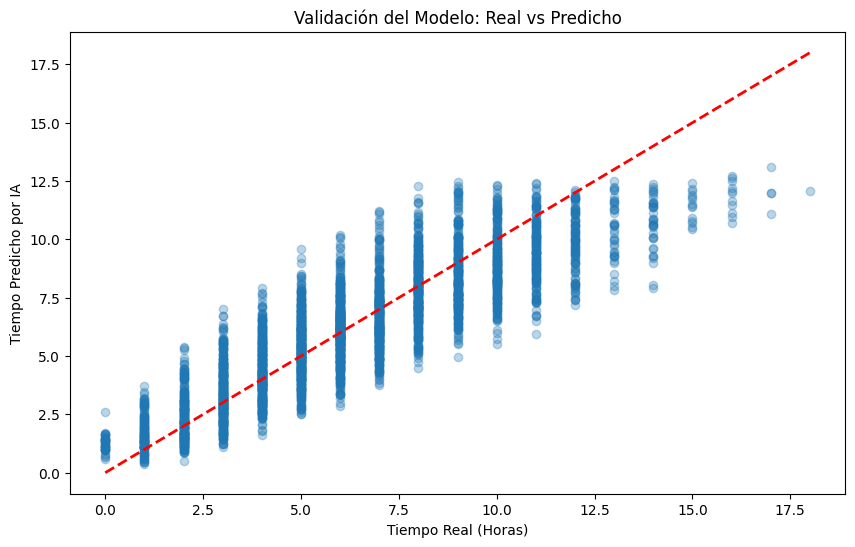

In [45]:
y_pred = model.predict(X_test_proc).flatten()

plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Tiempo Real (Horas)')
plt.ylabel('Tiempo Predicho por IA')
plt.title('Validación del Modelo: Real vs Predicho')
plt.show()

In [ ]:
y_train_binned = pd.cut(y_train, bins=5, labels=False)

In [18]:
model_11 = keras.Sequential([
    # Capa de entrada dinámica según las columnas procesadas
    keras.layers.Input(shape=(X_train_proc.shape[1],)),
    
    # Capas Ocultas (Arquitectura Base)
    keras.layers.Dense(64, activation='sigmoid'), # 64 neuronas
    keras.layers.Dense(32, activation='sigmoid'), # 32 neuronas
    
    # Capa de Salida (1 sola neurona lineal para regresión)
    keras.layers.Dense(1, activation='linear')
])

In [22]:
model_11.compile(
    optimizer= keras.optimizers.Adam(learning_rate=0.01),
    loss='mae', 
    metrics=['mae']
)

In [23]:
history = model_11.fit(
    X_train_proc, y_train,
    validation_data=(X_val_proc, y_val),
    batch_size=32,
    epochs=30, 
    verbose=0  
)

In [24]:
loss_mae = model_11.evaluate(X_test_proc, y_test, verbose=0)
print(f"\n--- RESULTADOS EXPERIMENTO 1 ---")
print(f"Error Absoluto Medio (MAE): {loss_mae[0]:.4f} horas")


--- RESULTADOS EXPERIMENTO 1 ---
Error Absoluto Medio (MAE): 1.3640 horas


######################################################################################################
SEGUNDO MODELO
######################################################################################################

In [194]:
model_2 = keras.Sequential([
    # Capa de entrada dinámica según las columnas procesadas
    keras.layers.Input(shape=(X_train_proc.shape[1],)),
    
    # Capas Ocultas (Arquitectura Base)
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'), # 64 neuronas
    keras.layers.Dense(32, activation='relu'), # 32 neuronas
    
    # Capa de Salida (1 sola neurona lineal para regresión)
    keras.layers.Dense(1, activation='linear')
])

In [195]:
model_2.compile(
    optimizer='adam',
    loss='mae', 
    metrics=['mae']
)

In [196]:
# Entrenamos (Usamos más epochs porque la red es más grande y tarda más en converger)
history = model_2.fit(
    X_train_proc, y_train,
    validation_data=(X_val_proc, y_val),
    batch_size=32,
    epochs=30, 
    verbose=0  
)

In [197]:
loss_2 = model_2.evaluate(X_test_proc, y_test, verbose=0)
print(f"Error MAE Final (Exp 2): {loss_2[0]:.4f} horas")

Error MAE Final (Exp 2): 1.3700 horas


118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step


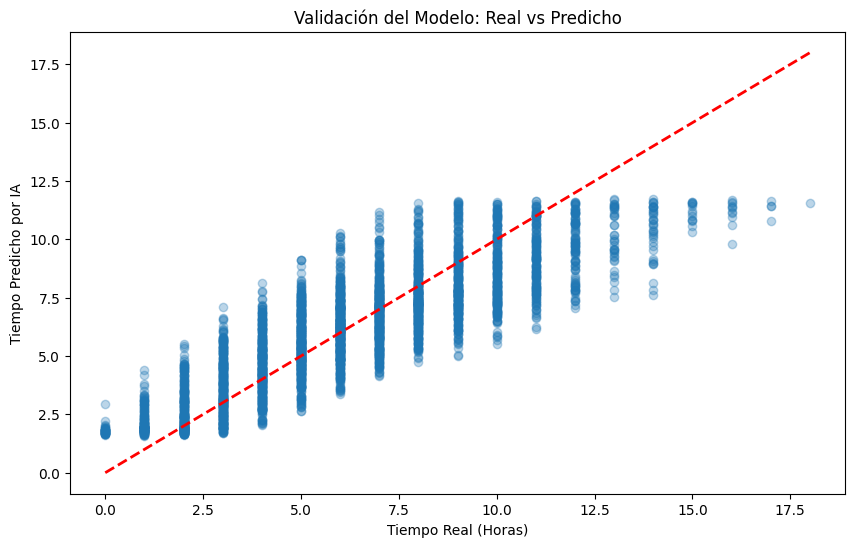

In [58]:
y_pred = model_2.predict(X_test_proc).flatten()

plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Tiempo Real (Horas)')
plt.ylabel('Tiempo Predicho por IA')
plt.title('Validación del Modelo: Real vs Predicho')
plt.show()

######################################################################################################
TERCER MODELO
######################################################################################################

In [140]:
model_3 = keras.Sequential([
     keras.layers.Input(shape=(X_train_proc.shape[1],)),
    
     keras.layers.Dense(256, activation='relu'),
     keras.layers.Dropout(0.3), # Apaga el 30% de las neuronas aleatoriamente (evita memoria)
    
     keras.layers.Dense(128, activation='relu'),
     keras.layers.Dropout(0.2), # Apaga el 20%
    
     keras.layers.Dense(64, activation='relu'),
     
    
     keras.layers.Dense(1, activation='linear')
])

In [78]:
# Configuramos un optimizador con Learning Rate personalizado
# Un valor más bajo (0.0005) ayuda a encontrar el mínimo global con más precisión
optimizer_custom = keras.optimizers.Adam(learning_rate=0.0005)

model_3.compile(
    optimizer=optimizer_custom,
    loss='mae',
    metrics=['mse']
)

In [79]:
# Agregamos EarlyStopping: Si el modelo deja de mejorar, para solo.
# Esto ahorra tiempo y es una técnica "profesional" muy valorada.
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [80]:
history_3 = model_3.fit(
    X_train_proc, y_train,
    validation_data=(X_val_proc, y_val),
    batch_size=64,
    epochs=100, # Ponemos muchas, el EarlyStopping lo cortará cuando esté listo
    callbacks=[early_stop],
    verbose=0
)

In [81]:
loss_3 = model_3.evaluate(X_test_proc, y_test, verbose=0)
print(f"Error MAE Final (Exp 3): {loss_3[0]:.4f} horas")

Error MAE Final (Exp 3): 1.3006 horas


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step


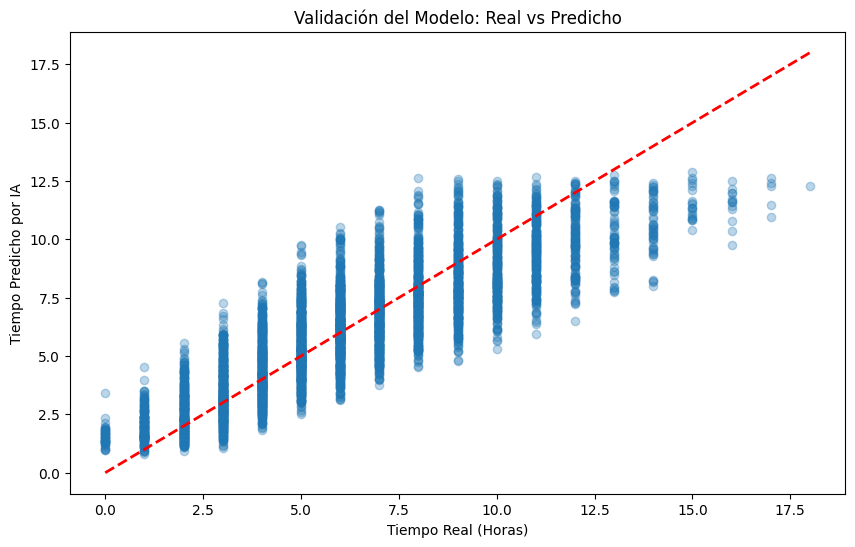

In [56]:
y_pred = model_3.predict(X_test_proc).flatten()

plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Tiempo Real (Horas)')
plt.ylabel('Tiempo Predicho por IA')
plt.title('Validación del Modelo: Real vs Predicho')
plt.show()